# Paper Figures

1. Setup
1. Import
  - Metadata
  - Trees
    - Divergence tree
    - Timetree
    - Mugration Country Tree

---
# 1. Setup

## Modules

In [6]:
import os
from Bio import Phylo, AlignIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec, lines
import scipy
import math
import numpy as np
import geopandas
import datetime
import shapely
import copy
from geopy import distance
import geopy
import cartopy.crs as ccrs

from plot_phylo_functions import *

## Paths

In [7]:
project_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/"

# ------------------------------------------
# Trees
divtree_path          = project_dir + "iqtree/all/chromosome/full/filter5/iqtree.filter.nwk"
timetree_path         = project_dir + "lsd/all/chromosome/full/filter5/lsd.nex"
mugtree_country_path  = project_dir + "mugration/all/chromosome/full/filter5/mugration_country.nex"
mugtree_province_path = project_dir + "mugration/all/chromosome/full/filter5/mugration_province.nex"
mugtree_branch_major_path = project_dir + "mugration/all/chromosome/full/filter5/mugration_branch_major.nex"
# ------------------------------------------
# Alignment
constant_sites_path   = project_dir + "snippy_multi/all/chromosome/full/snippy-multi.constant_sites.txt"
aln_path              = project_dir + "lsd/all/chromosome/full/filter5/lsd.filter.aln"

# ------------------------------------------
# Metadata
metadata_path         = project_dir + "lsd/all/chromosome/full/filter5/metadata.tsv"
mugconf_country_path  = project_dir + "mugration/all/chromosome/full/filter5/mugration_country_confidence.csv"
mugstates_country_path  = project_dir + "mugration/all/chromosome/full/filter5/mugration_country_states.csv"
mugconf_province_path  = project_dir + "mugration/all/chromosome/full/filter5/mugration_province_confidence.csv"
mugstates_province_path  = project_dir + "mugration/all/chromosome/full/filter5/mugration_province_states.csv"
mugconf_branch_major_path  = project_dir + "mugration/all/chromosome/full/filter5/mugration_branch_major_confidence.csv"
mugstates_branch_major_path  = project_dir + "mugration/all/chromosome/full/filter5/mugration_branch_major_states.csv"
# ------------------------------------------
# Other
xu_2019_path          = project_dir + "figures/xu2019.csv"

# ------------------------------------------
# Output
out_dir = project_dir + "figures/"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

## Variables

In [8]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)

NO_DATA_CHAR = "NA"
CURRENT_YEAR = datetime.datetime.utcnow().year

# ------------------------------------------
# Alignment
with open(constant_sites_path) as infile:
    data = infile.read().strip().split(",")
    constant_sites = sum([int(count) for count in data])

aln = AlignIO.read(aln_path, "fasta")
variant_sites = len(aln[0].seq)
SEQ_LEN = constant_sites + variant_sites

# ------------------------------------------
# Geo
CRS = "epsg:3857"
CRS_EPSG = ccrs.epsg('3857')
world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# ------------------------------------------
# Reference
REF_STRAIN = "CO92"
REF_LAT = "38.7251776"
REF_LON = "-105.607716"
REF_DATE_BP = 1992 - CURRENT_YEAR
REF_BRANCH_MAJOR = "1.ORI"
REF_BRANCH_MINOR = "1.ORI1"
REF_BRANCH_NUMBER = "1"
REF_COUNTRY = "United States of America"
REF_PROVINCE = "Colorado"
REF_CONTINENT = "North America"

# ------------------------------------------
# Plotting
SM_FONT = 4
MED_FONT = 6
LG_FONT = 8
D3_PAL = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf" ]

# ------------------------------------------
BRANCH_LIST = {
    "0.PRE": ["0.PRE1", "0.PRE2"], 
    "0.ANT4" : ["0.ANT4"], 
    "0.PE": ["0.PE4m", "0.PE4m", "0.PE4t", "0.PE4a", "0.PE5"],   
    "0.ANT": ["0.ANT1", "0.ANT2","0.ANT3","0.ANT5"],     
    "1.PRE" : ["1.PRE1", "1.PRE2", "1.PRE3"],    
    "1.ANT": ["1.ANT1"], 
    "1.IN": ["1.IN1","1.IN2","1.IN3"],   
    "1.ORI" : ["1.ORI1", "1.ORI2", "1.ORI3"],
    "2.ANT": ["2.ANT1","2.ANT2","2.ANT3" ], 
    "2.MED": ["2.MED0", "2.MED1","2.MED2","2.MED3" ], 
    "3.ANT": ["3.ANT1", "3.ANT2" ],     
    "4.ANT": ["4.ANT1" ],           
}

ANCIENT_BRANCH_LIST = {
    "0.PRE": ["0.PRE1", "0.PRE2"], 
    "0.ANT4" : ["0.ANT4"],  
    "1.PRE" : ["1.PRE1", "1.PRE2", "1.PRE3"],     
}


---
# 2. Import

## Mugration Confidence Tables

In [9]:
states_files = [mugstates_country_path, mugstates_province_path, mugstates_branch_major_path]
conf_files = [mugconf_country_path, mugconf_province_path, mugconf_branch_major_path]

# ----------------------------------------
# Convert character states to numbers
for mugstates,mugconf in zip(states_files, conf_files):
    node_i = 0
    conf_basename = os.path.splitext(mugconf)[0]
    conf_outname = conf_basename + "_tidy.csv"
    i = -1
    state_dict = {}
    with open(mugstates, "r") as infile:
        read_line = infile.readline()
        while read_line:
            split_line = read_line.strip().split(",")
            state = split_line[1]
            if state == "nan":
                state = "NA"
            state_dict[i] = state
            read_line = infile.readline()
            i += 1
    # Swap first to last place
    final_i = len(state_dict) - 1
    state_dict[final_i] = "?"
    # Remove old first
    state_dict.pop(-1)


    with open(mugconf, "r") as infile:            
        i = 0
        read_line = infile.readline()
        header = read_line.strip().split(", ")
        header[0] = "name"

        data = ""
        for i in range(0, len(header) - 1):
            char = header[i + 1]
            header[i + 1] = state_dict[i]
        header = ",".join(header)
        read_line = infile.readline()            
        while read_line:
            # Rename internal nodes
            split_line = read_line.split(", ")
            node_name = split_line[0]
            if "NODE" in node_name:
                node_name = "NODE{}".format(node_i)
                node_i += 1
            new_line = ",".join([node_name] + split_line[1:])
            data += new_line
            read_line = infile.readline()
    
    with open(conf_outname, "w") as outfile:
        outfile.write(header + "\n")
        outfile.write(data)

# ----------------------------------------
# Import the tidy files as dataframes
mugconf_country_tidy_path = os.path.splitext(mugconf_country_path)[0] + "_tidy.csv"
mugconf_country_df = pd.read_csv(mugconf_country_tidy_path, sep=',', index_col = 0)

mugconf_province_tidy_path = os.path.splitext(mugconf_province_path)[0] + "_tidy.csv"
mugconf_province_df = pd.read_csv(mugconf_province_tidy_path, sep=',', index_col = 0)

mugconf_branch_major_tidy_path = os.path.splitext(mugconf_branch_major_path)[0] + "_tidy.csv"
mugconf_branch_major_df = pd.read_csv(mugconf_branch_major_tidy_path, sep=',', index_col = 0)

## Trees

In [10]:
tree_paths = [divtree_path, timetree_path, mugtree_country_path, mugtree_province_path, mugtree_branch_major_path ]

for tree_path in tree_paths:
    tree_ext = os.path.splitext(tree_path)[1]
    if tree_ext == ".nwk":
        tree = Phylo.read(tree_path, "newick")
    elif tree_ext == ".nex":
        parse_trees = Phylo.parse(tree_path, "nexus")
        for parse_tree in parse_trees:
            clades = [c for c in parse_tree.find_clades()]
            if len(clades) > 1:
                break
        tree = parse_tree
    tree.ladderize(reverse=False)
    
    if tree_path == divtree_path:
        print(divtree_path)
        divtree = tree
    elif tree_path == timetree_path:
        print(timetree_path)        
        timetree = tree    
    elif tree_path == mugtree_country_path:
        print(mugtree_country_path)        
        mugtree_country = tree    
    elif tree_path == mugtree_province_path:
        print(mugtree_province_path)         
        mugtree_province = tree  
    elif tree_path == mugtree_branch_major_path:
        print(mugtree_branch_major_path)         
        mugtree_branch_major = tree            
    

/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/iqtree/all/chromosome/full/filter5/iqtree.filter.nwk
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/lsd/all/chromosome/full/filter5/lsd.nex
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/mugration/all/chromosome/full/filter5/mugration_country.nex
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/mugration/all/chromosome/full/filter5/mugration_province.nex
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/mugration/all/chromosome/full/filter5/mugration_branch_major.nex


## Import Metadata

### Modern Human Cases

In [11]:
xu_2019_df = pd.read_csv(xu_2019_path, sep=',')

### Project Data

In [12]:
metadata_df = pd.read_csv(metadata_path, sep='\t')
metadata_df.set_index(metadata_df.columns[0], inplace=True)

# Add Missing Reference metadata
metadata_df.at["Reference", "strain"] = REF_STRAIN
metadata_df.at["Reference", "date"] = CURRENT_YEAR - REF_DATE_BP
metadata_df.at["Reference", "date_bp"] = REF_DATE_BP
metadata_df.at["Reference", "province_lat"] = REF_LAT
metadata_df.at["Reference", "province_lon"] = REF_LON
metadata_df.at["Reference", "branch_major"] = REF_BRANCH_MAJOR
metadata_df.at["Reference", "branch_minor"] = REF_BRANCH_MINOR
metadata_df.at["Reference", "branch_number"] = REF_BRANCH_NUMBER
metadata_df.at["Reference", "country"] = REF_COUNTRY
metadata_df.at["Reference", "province"] = REF_PROVINCE
metadata_df.at["Reference", "continent"] = REF_CONTINENT
metadata_df.at["Reference", "biosample_comment"] = "KEEP: Assembly Modern Reference"

metadata_df.fillna(NO_DATA_CHAR, inplace=True)

### Tree Data

In [42]:
# Check if they're synchronized
node_i = 0

for cd,ct,cmc,cmp,cmbmaj in zip(
        divtree.find_clades(), 
        timetree.find_clades(), 
        mugtree_country.find_clades(),
        mugtree_province.find_clades(),
        mugtree_branch_major.find_clades(),    
    ):
    # Rename internal nodes
    if not cd.name or "NODE" in cmc.name:
        cd.name = "NODE{}".format(node_i)
        ct.name = "NODE{}".format(node_i)
        cmc.name = "NODE{}".format(node_i) 
        cmp.name = "NODE{}".format(node_i) 
        cmbmaj.name = "NODE{}".format(node_i) 
        node_i += 1
        
    if cd.name != ct.name or cd.name != cmc.name or cd.name != cmp.name:
        print("ERROR. Trees are not synchronized.")
        print(cd.name, ct.name, cmc.name, cmp.name, cmbmaj.name)
        break
        
    node_name = cd.name
    
    # node type
    node_type = "internal"
    if cd.is_terminal():
        node_type = "terminal"
    metadata_df.at[node_name, "node_type"] = node_type

    # Branch Support
    # Give terminal nodes 100% confidence
    branch_support = cd.confidence
    if cd.is_terminal():
        branch_support = 100
    # Internal nodes without confidence can be 0
    elif not cd.confidence:
        branch_support = 0
    metadata_df.at[node_name, "branch_support"] = branch_support
    
    comment_dict = {}
    # Mugration  Country
    if cmc.comment:
        cmc_comment_dict = parse_comment(cmc.comment)
        for attr in cmc_comment_dict:
            comment_dict["mugration_" + attr] = cmc_comment_dict[attr]
            
    # Mugration  Province
    if cmp.comment:
        cmp_comment_dict = parse_comment(cmp.comment)
        for attr in cmp_comment_dict:
            comment_dict["mugration_" + attr] = cmp_comment_dict[attr]            
            
    # Mugration Branch Major
    if cmbmaj.comment:
        cmbmaj_comment_dict = parse_comment(cmbmaj.comment)
        for attr in cmbmaj_comment_dict:
            comment_dict["mugration_" + attr] = cmbmaj_comment_dict[attr]            

    # Time Tree         
    if ct.comment:
        ct_comment_dict = parse_comment(ct.comment)
        for attr in ct_comment_dict:
            comment_dict["timetree_" + attr] = ct_comment_dict[attr]
            
    for attr in comment_dict:
        metadata_df.at[node_name, attr] = comment_dict[attr]
           
metadata_df.fillna(NO_DATA_CHAR, inplace=True)
display(metadata_df)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,node_type,branch_support,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_branch_major,mugration_country_lat,mugration_country_lon,mugration_country_confidence,mugration_province_lat,mugration_province_lon,mugration_province_confidence,geometry,geometry_size,divtree_coord_x,divtree_coord_y,rtt_dist,branch_major_color,date_mean,date_err,date_lower,date_upper,timetree_coord_x,timetree_coord_y
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,terminal,100.0,-98,NA,NA,Russia,Rostov Oblast,2.MED,64.686314,97.745306,1.000000,47.622245,40.795794,1.000000,POINT (40.79579 47.62225),4.0,0.000073,339.00,0.000073,#97fca7,1923,0,1923,1923,6259.03230,339.00
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,terminal,100.0,-15,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000054,152.00,0.000054,#238af5,2006,0,2006,2006,6342.03339,152.00
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,terminal,100.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000055,171.00,0.000055,#238af5,2005,0,2005,2005,6341.03334,171.00
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,terminal,100.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000055,173.00,0.000055,#238af5,2005,0,2005,2005,6341.03334,173.00
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722922,KEEP: Assembly Modern,0,Asia,terminal,100.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000055,165.00,0.000055,#238af5,2005,0,2005,2005,6341.03334,165.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE595,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,13.0,-147.664,"{150.036,212.137}","{-183.137,-121.036}",Peru,Cajamarca,1.ORI,-6.869970,-75.045851,1.000000,-6.250000,-78.833333,0.994564,POINT (-78.83333 -6.25000),18.0,0.000072,598.25,0.000072,#ff4824,NA,NA,NA,NA,6209.36816,598.25
NODE596,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,13.0,-147.664,"{150.036,212.137}","{-183.137,-121.036}",Peru,Cajamarca,1.ORI,-6.869970,-75.045851,1.000000,-6.250000,-78.833333,0.994580,POINT (-78.83333 -6.25000),18.0,0.000072,596.75,0.000072,#ff4824,NA,NA,NA,NA,6209.36816,596.75
NODE597,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,46.0,-108.537,"{92.2612,187.129}","{-158.129,-63.2612}",Peru,Cajamarca,1.ORI,-6.869970,-75.045851,0.999997,-6.250000,-78.833333,0.999921,POINT (-78.83333 -6.25000),18.0,0.000073,597.50,0.000073,#ff4824,NA,NA,NA,NA,6248.49486,597.50


### Handle Root

In [14]:
df_list = [mugconf_country_df, mugconf_province_df, mugconf_branch_major_df]
attr_list = ["country", "province", "branch_major"]

for df,attr in zip(df_list, attr_list):
    max_state = ""
    max_val = 0
    for state,val in zip(df.columns, df.loc["NODE0"]):
        if val >= max_val:
            max_val = val
            max_state = state
    metadata_df["mugration_" + attr]["NODE0"] = max_state

display(metadata_df.loc["NODE0"])

/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


strain                                    NA
date                                      NA
date_bp                                   NA
country                                   NA
province                                  NA
                                 ...        
timetree_CI_height          {5904.45,6737.2}
timetree_CI_date          {-6708.2,-5875.45}
mugration_country                     Russia
mugration_province                   Bavaria
mugration_branch_major                 0.PRE
Name: NODE0, Length: 24, dtype: object

### Lat Lon

In [18]:
latlon_country_df = pd.DataFrame()
latlon_province_df = pd.DataFrame()

df_list = [latlon_country_df, latlon_province_df]
attr_list = ["country", "province"]
conf_df_list = [mugconf_country_df, mugconf_province_df]

# Create a mapping of geo name to lat,lon
for df,attr in zip(df_list, attr_list):
    # Get data
    for rec in metadata_df.iterrows():
        node_name = rec[0]
        name = rec[1][attr]
        lat = rec[1][attr + "_lat"]
        lon = rec[1][attr + "_lon"] 
        
        if name == NO_DATA_CHAR: continue

        if name not in df.index:

            df.at[name, "lat"] = lat
            df.at[name, "lon"] = lon
            df.at[name, "size"] = 1
        else:
            df["size"][name] += 1

#display(latlon_country_df)
#display(latlon_province_df)


# Update lat lon for mugration
for latlon_df, conf_df, attr in zip(df_list, conf_df_list, attr_list):
    for rec in metadata_df.iterrows():
        sample = rec[0]
        name = rec[1]["mugration_" + attr]  
        lat = latlon_df["lat"][name]
        lon = latlon_df["lon"][name]

        # Get confidence
        max_val = 0
        for state,val in zip(conf_df.columns, conf_df.loc[sample]):
            if val >= max_val:
                max_state = state
                max_val = val
                
        metadata_df.at[sample, "mugration_" + attr +"_lat"] = lat
        metadata_df.at[sample, "mugration_" + attr +"_lon"] = lon
        metadata_df.at[sample, "mugration_" + attr +"_confidence"] = max_val

display(metadata_df)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,node_type,branch_support,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_branch_major,mugration_country_lat,mugration_country_lon,mugration_country_confidence,mugration_province_lat,mugration_province_lon,mugration_province_confidence
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,terminal,0.0,-98,NA,NA,Russia,Rostov Oblast,2.MED,64.686314,97.745306,1.000000,47.622245,40.795794,1.000000
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,terminal,0.0,-15,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,terminal,0.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,terminal,0.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722922,KEEP: Assembly Modern,0,Asia,terminal,0.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE595,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,13.0,-147.664,"{150.036,212.137}","{-183.137,-121.036}",Peru,Cajamarca,1.ORI,-6.869970,-75.045851,1.000000,-6.250000,-78.833333,0.994564
NODE596,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,13.0,-147.664,"{150.036,212.137}","{-183.137,-121.036}",Peru,Cajamarca,1.ORI,-6.869970,-75.045851,1.000000,-6.250000,-78.833333,0.994580
NODE597,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,46.0,-108.537,"{92.2612,187.129}","{-158.129,-63.2612}",Peru,Cajamarca,1.ORI,-6.869970,-75.045851,0.999997,-6.250000,-78.833333,0.999921


---
# Convert Dataframes to Geopandas

### Modern Human Cases

<GeoAxesSubplot:>

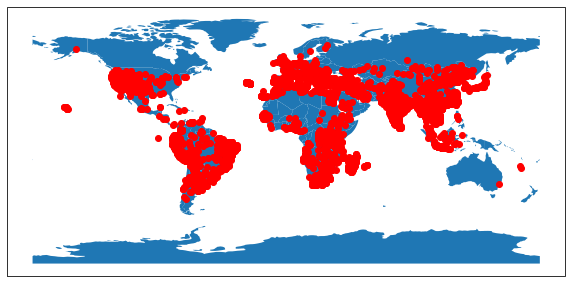

In [19]:
geometry = []

for rec in xu_2019_df.iterrows():
    sample = rec[0]
    lon = float(rec[1]["X"].replace("'",""))
    lat = float(rec[1]["Y"].replace("'",""))
    point = shapely.geometry.Point(lon,lat)
    geometry.append(point)

xu_2019_gdf = geopandas.GeoDataFrame(xu_2019_df, crs=CRS, geometry=geometry)

# Generate a figure with two axes, one for CartoPy, one for GeoPandas
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},
                        figsize=(10, 5))
world_polygons.plot(ax=ax)
xu_2019_gdf.plot(ax=ax, c="red")

### Project Data

<GeoAxesSubplot:>

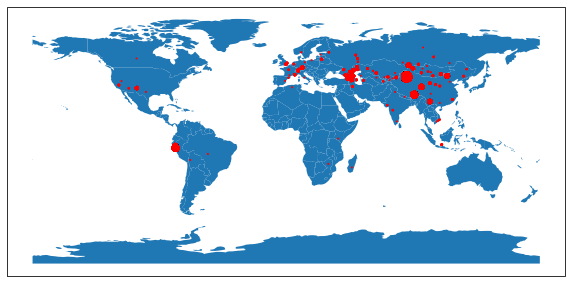

In [21]:
attr = "province"
latlon_df = latlon_province_df

geometry = []

for rec in metadata_df.iterrows():
    sample = rec[0]
    name = rec[1]["mugration_" + attr]
    lat = rec[1]["mugration_" + attr + "_lat"]
    lon = rec[1]["mugration_" + attr + "_lon"]
    size = latlon_df["size"][name]
    point = shapely.geometry.Point(lon,lat)
    geometry.append(point)


metadata_gdf = geopandas.GeoDataFrame(metadata_df, crs="epsg:3857", geometry=geometry)

# Add geometry size
for rec in metadata_gdf.iterrows():
    sample = rec[0]
    name = rec[1]["mugration_" + attr]
    size = latlon_df["size"][name]  
    metadata_gdf.at[sample, "geometry_size"] = size
    


# Test map

# Generate a figure with two axes, one for CartoPy, one for GeoPandas
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},
                        figsize=(10, 5))
world_polygons.plot(ax=ax)
metadata_gdf.plot(ax=ax, c="red", markersize="geometry_size")

# Colors

Use the full tree for color order

In [22]:
# Colors
attr_states = list(dict.fromkeys(metadata_gdf["branch_major"]))
# Create the custom color map (pyplot)
cmap = plt.get_cmap("rainbow", len(attr_states))
# Convert the color map to a list of RGB values
cmaplist = [cmap(i) for i in range(cmap.N)]
# Convert RGB values to hex colors
attr_hex = [colors.to_hex(col) for col in cmaplist]
colors_dict = {}

# Assign states colors based on tip order
i_hex = 0
for c in divtree.get_terminals():
    if c.name == "Reference":
        branch = "1.ORI"
    else:
        branch = metadata_gdf["branch_major"][c.name]
    if branch not in colors_dict:
        colors_dict[branch] = attr_hex[i_hex]
        i_hex += 1
        
print(colors_dict)

{'0.PRE': '#8000ff', '0.PE': '#5148fc', '0.ANT': '#238af5', '3.ANT': '#0cc1e8', '4.ANT': '#3ae8d7', '2.ANT': '#68fcc1', '2.MED': '#97fca7', '1.PRE': '#c5e88a', '1.ANT': '#f3c16a', '1.IN': '#ff8a48', '1.ORI': '#ff4824'}


---
# Parse Tree Into Dataframe

In [23]:
x_posns = get_x_positions(divtree)
y_posns = get_y_positions(divtree)

for c in divtree.find_clades():

    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    metadata_gdf.at[c.name, 'divtree_coord_x'] = coord_x
    metadata_gdf.at[c.name, 'divtree_coord_y'] = coord_y
    
    metadata_gdf.at[c.name, "rtt_dist"] = coord_x
    
    branch_minor = metadata_gdf["branch_minor"][c.name]
    if branch_minor != NO_DATA_CHAR:
        # Remove letters at end
        while branch_minor[-1].isalpha():
            branch_minor = branch_minor[:-1]    
    metadata_gdf.at[c.name, "branch_minor"] = branch_minor
    
    branch_major = metadata_gdf["mugration_branch_major"][c.name]
    branch_major_color = colors_dict[branch_major]
    metadata_gdf.at[c.name, "branch_major_color"] = branch_major_color    

    date_bp = metadata_gdf["date_bp"][c.name]
    if date_bp == NO_DATA_CHAR:
        continue
    
    elif type(date_bp) == int:
        date_bp = str(date_bp)
    date_split = date_bp.strip("[]").split(":")
    date_range = [int(d) for d in date_split]
    if len(date_range) == 1:
        date_range = [date_range[0], date_range[0]]
    date_mean = sum(date_range) / len(date_range)

    calendar_date = int(date_mean) + CURRENT_YEAR
    calendar_date_lower = date_range[0] + CURRENT_YEAR
    calendar_date_upper = date_range[1] + CURRENT_YEAR
    date_err = abs(date_mean - date_range[0])

    metadata_gdf.at[c.name, "date_mean"] = calendar_date
    metadata_gdf.at[c.name, "date_err"] = date_err
    metadata_gdf.at[c.name, "date_lower"] = calendar_date_lower
    metadata_gdf.at[c.name, "date_upper"] = calendar_date_upper

x_posns = get_x_positions(timetree)
y_posns = get_y_positions(timetree)


for c in timetree.find_clades():

    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    metadata_gdf.at[c.name, 'timetree_coord_x'] = coord_x
    metadata_gdf.at[c.name, 'timetree_coord_y'] = coord_y
        

display(metadata_gdf)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,node_type,branch_support,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_branch_major,mugration_country_lat,mugration_country_lon,mugration_country_confidence,mugration_province_lat,mugration_province_lon,mugration_province_confidence,geometry,geometry_size,divtree_coord_x,divtree_coord_y,rtt_dist,branch_major_color,date_mean,date_err,date_lower,date_upper,timetree_coord_x,timetree_coord_y
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,terminal,0.0,-98,NA,NA,Russia,Rostov Oblast,2.MED,64.686314,97.745306,1.000000,47.622245,40.795794,1.000000,POINT (40.79579 47.62225),4.0,0.000073,339.00,0.000073,#97fca7,1923.0,0.0,1923.0,1923.0,6259.03230,339.00
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,terminal,0.0,-15,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000054,152.00,0.000054,#238af5,2006.0,0.0,2006.0,2006.0,6342.03339,152.00
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,terminal,0.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000055,171.00,0.000055,#238af5,2005.0,0.0,2005.0,2005.0,6341.03334,171.00
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,terminal,0.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000055,173.00,0.000055,#238af5,2005.0,0.0,2005.0,2005.0,6341.03334,173.00
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722922,KEEP: Assembly Modern,0,Asia,terminal,0.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000055,165.00,0.000055,#238af5,2005.0,0.0,2005.0,2005.0,6341.03334,165.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE595,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,13.0,-147.664,"{150.036,212.137}","{-183.137,-121.036}",Peru,Cajamarca,1.ORI,-6.869970,-75.045851,1.000000,-6.250000,-78.833333,0.994564,POINT (-78.83333 -6.25000),18.0,0.000072,598.25,0.000072,#ff4824,NaN,NaN,NaN,NaN,6209.36816,598.25
NODE596,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,13.0,-147.664,"{150.036,212.137}","{-183.137,-121.036}",Peru,Cajamarca,1.ORI,-6.869970,-75.045851,1.000000,-6.250000,-78.833333,0.994580,POINT (-78.83333 -6.25000),18.0,0.000072,596.75,0.000072,#ff4824,NaN,NaN,NaN,NaN,6209.36816,596.75
NODE597,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,46.0,-108.537,"{92.2612,187.129}","{-158.129,-63.2612}",Peru,Cajamarca,1.ORI,-6.869970,-75.045851,0.999997,-6.250000,-78.833333,0.999921,POINT (-78.83333 -6.25000),18.0,0.000073,597.50,0.000073,#ff4824,NaN,NaN,NaN,NaN,6248.49486,597.50


In [24]:
# Marker sizes
ancient_gdf = metadata_gdf[metadata_gdf["biosample_comment"].str.contains("Ancient")]
modern_gdf  = metadata_gdf[metadata_gdf["biosample_comment"].str.contains("Modern")]

display(modern_gdf)
display(modern_gdf)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,node_type,branch_support,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_branch_major,mugration_country_lat,mugration_country_lon,mugration_country_confidence,mugration_province_lat,mugration_province_lon,mugration_province_confidence,geometry,geometry_size,divtree_coord_x,divtree_coord_y,rtt_dist,branch_major_color,date_mean,date_err,date_lower,date_upper,timetree_coord_x,timetree_coord_y
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,terminal,0.0,-98,NA,NA,Russia,Rostov Oblast,2.MED,64.686314,97.745306,1.000000,47.622245,40.795794,1.000000,POINT (40.79579 47.62225),4.0,0.000073,339.0,0.000073,#97fca7,1923.0,0.0,1923.0,1923.0,6259.03230,339.0
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,terminal,0.0,-15,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000054,152.0,0.000054,#238af5,2006.0,0.0,2006.0,2006.0,6342.03339,152.0
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,terminal,0.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000055,171.0,0.000055,#238af5,2005.0,0.0,2005.0,2005.0,6341.03334,171.0
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,terminal,0.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000055,173.0,0.000055,#238af5,2005.0,0.0,2005.0,2005.0,6341.03334,173.0
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722922,KEEP: Assembly Modern,0,Asia,terminal,0.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000055,165.0,0.000055,#238af5,2005.0,0.0,2005.0,2005.0,6341.03334,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_010974835.1_ASM1097483v1_genomic,7,1922,-99,Kazakhstan,West Kazakhstan Region,47.2286,65.2093,49.5568,50.2227,Medievalis,2.MED,2.MED1,SAMN14090012,KEEP: Assembly Modern,2,Asia,terminal,0.0,-99,NA,NA,Kazakhstan,West Kazakhstan Region,2.MED,47.228609,65.209320,1.000000,49.556848,50.222741,1.000000,POINT (50.22274 49.55685),6.0,0.000076,341.0,0.000076,#97fca7,1922.0,0.0,1922.0,1922.0,6258.03160,341.0
GCA_010974845.1_ASM1097484v1_genomic,578,1945,-76,Kazakhstan,Kyzylorda Region,47.2286,65.2093,45.2059,63.9155,Medievalis,2.MED,2.MED1,SAMN14089970,KEEP: Assembly Modern,2,Asia,terminal,0.0,-76,NA,NA,Kazakhstan,Kyzylorda Region,2.MED,47.228609,65.209320,1.000000,45.205885,63.915520,1.000000,POINT (63.91552 45.20589),4.0,0.000074,368.0,0.000074,#97fca7,1945.0,0.0,1945.0,1945.0,6281.03240,368.0
GCA_009909645.1_ASM990964v1_genomic,111,1971,-50,Russia,Astrakhan Oblast,64.6863,97.7453,47.1878,47.6089,Medievalis,2.MED,2.MED1,SAMN13632895,KEEP: Assembly Modern,2,Europe,terminal,0.0,-50,NA,NA,Russia,Astrakhan Oblast,2.MED,64.686314,97.745306,1.000000,47.187819,47.608851,1.000000,POINT (47.60885 47.18782),9.0,0.000074,381.0,0.000074,#97fca7,1971.0,0.0,1971.0,1971.0,6307.03226,381.0


,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,node_type,branch_support,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_branch_major,mugration_country_lat,mugration_country_lon,mugration_country_confidence,mugration_province_lat,mugration_province_lon,mugration_province_confidence,geometry,geometry_size,divtree_coord_x,divtree_coord_y,rtt_dist,branch_major_color,date_mean,date_err,date_lower,date_upper,timetree_coord_x,timetree_coord_y
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,terminal,0.0,-98,NA,NA,Russia,Rostov Oblast,2.MED,64.686314,97.745306,1.000000,47.622245,40.795794,1.000000,POINT (40.79579 47.62225),4.0,0.000073,339.0,0.000073,#97fca7,1923.0,0.0,1923.0,1923.0,6259.03230,339.0
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,terminal,0.0,-15,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000054,152.0,0.000054,#238af5,2006.0,0.0,2006.0,2006.0,6342.03339,152.0
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,terminal,0.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000055,171.0,0.000055,#238af5,2005.0,0.0,2005.0,2005.0,6341.03334,171.0
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,terminal,0.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000055,173.0,0.000055,#238af5,2005.0,0.0,2005.0,2005.0,6341.03334,173.0
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722922,KEEP: Assembly Modern,0,Asia,terminal,0.0,-16,NA,NA,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,POINT (85.46335 42.48050),105.0,0.000055,165.0,0.000055,#238af5,2005.0,0.0,2005.0,2005.0,6341.03334,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_010974835.1_ASM1097483v1_genomic,7,1922,-99,Kazakhstan,West Kazakhstan Region,47.2286,65.2093,49.5568,50.2227,Medievalis,2.MED,2.MED1,SAMN14090012,KEEP: Assembly Modern,2,Asia,terminal,0.0,-99,NA,NA,Kazakhstan,West Kazakhstan Region,2.MED,47.228609,65.209320,1.000000,49.556848,50.222741,1.000000,POINT (50.22274 49.55685),6.0,0.000076,341.0,0.000076,#97fca7,1922.0,0.0,1922.0,1922.0,6258.03160,341.0
GCA_010974845.1_ASM1097484v1_genomic,578,1945,-76,Kazakhstan,Kyzylorda Region,47.2286,65.2093,45.2059,63.9155,Medievalis,2.MED,2.MED1,SAMN14089970,KEEP: Assembly Modern,2,Asia,terminal,0.0,-76,NA,NA,Kazakhstan,Kyzylorda Region,2.MED,47.228609,65.209320,1.000000,45.205885,63.915520,1.000000,POINT (63.91552 45.20589),4.0,0.000074,368.0,0.000074,#97fca7,1945.0,0.0,1945.0,1945.0,6281.03240,368.0
GCA_009909645.1_ASM990964v1_genomic,111,1971,-50,Russia,Astrakhan Oblast,64.6863,97.7453,47.1878,47.6089,Medievalis,2.MED,2.MED1,SAMN13632895,KEEP: Assembly Modern,2,Europe,terminal,0.0,-50,NA,NA,Russia,Astrakhan Oblast,2.MED,64.686314,97.745306,1.000000,47.187819,47.608851,1.000000,POINT (47.60885 47.18782),9.0,0.000074,381.0,0.000074,#97fca7,1971.0,0.0,1971.0,1971.0,6307.03226,381.0


---
# Plot RTT

## All

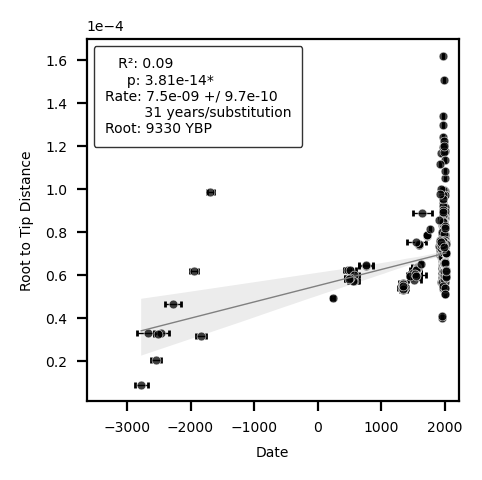

In [26]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

geo_dist_all = []
genetic_dist_all = []

fig, ax = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)

df = metadata_gdf[metadata_gdf["node_type"] == "terminal"]
reg_x = "date_mean"
reg_y = "rtt_dist"
reg_err = "date_err"

# -----------------------
# Regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df["date_mean"],df["rtt_dist"])
r2 = r_value * r_value    
y_intercept = CURRENT_YEAR - (0 - intercept)/slope
p_sig = ""
p_thresh = 0.05    
if p_value < p_thresh:
    p_sig = "*"

mut_per_year = SEQ_LEN * slope
year_per_mut = 1 / mut_per_year

reg_dict = {
    "slope": slope,
    "x_intercept" : intercept,
    "y_intercept" : y_intercept,
    "p_value" : p_value,
    "p_sig" : p_sig,
    "year_per_mut" : year_per_mut
}

sns.regplot(
    ax=ax,
    data=df, 
    x=reg_x, 
    y=reg_y, 
    #robust=True,
    ci=95,
    scatter_kws={"s": 0},
    line_kws={"linewidth" : 0.5},
    color="grey",
    #color=df["branch_major_color"][0],
    label=(
    "   R²: {}".format(round(r2,2))
    + "\n     p: {:.2e}{}".format(p_value, p_sig)
    + "\nRate: {:.2} +/ {:.2}".format(slope, std_err)  
    + "\n         {} years/substitution".format(round(year_per_mut))
    + "\nRoot: {} YBP".format(round(y_intercept))                
    )
)

ax.errorbar(
    data=df, 
    x=reg_x, 
    y=reg_y, 
    xerr=reg_err,
    yerr=None,
    ls='none',
    c = "black",  
    capsize=1,
    label=None,
    zorder=1,
    lw=0.5,
    )  

sns.scatterplot(
    ax=ax,
    data=df, 
    x=reg_x, 
    y=reg_y, 
    s=10,    
    ec = "white", 
    color="black",
    alpha=0.75,
    zorder=2,
) 

    
# Set xlimits
xlim = ax.get_xlim()
x_buff = round((xlim[1] - xlim[0]) * 0.1,1)
new_xlim = [xlim[0]-x_buff, xlim[1]+x_buff]
if new_xlim[1] > CURRENT_YEAR:
    new_xlim = [new_xlim[0], CURRENT_YEAR + 200]
ax.set_xlim(new_xlim)
    
ax.set_ylabel("Root to Tip Distance")
ax.set_xlabel("Date")    
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) 

# Format and position legend
legend = ax.legend(
    borderpad=0.8, 
    handletextpad=-2, 
    edgecolor="black", 
    #bbox_to_anchor=(0.5, -0.30), 
    #loc='center',
    fontsize=FONTSIZE,
)
frame = legend.get_frame().set_linewidth(0.5)

out_path = os.path.join(out_dir, "rtt_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

Branch: 0.PRE
Branch: 0.ANT4
Branch: 0.PE
Branch: 0.ANT
Branch: 1.PRE
Branch: 1.ANT
Branch: 1.IN
Branch: 1.ORI
Branch: 2.ANT
Branch: 2.MED
Branch: 3.ANT
Branch: 4.ANT


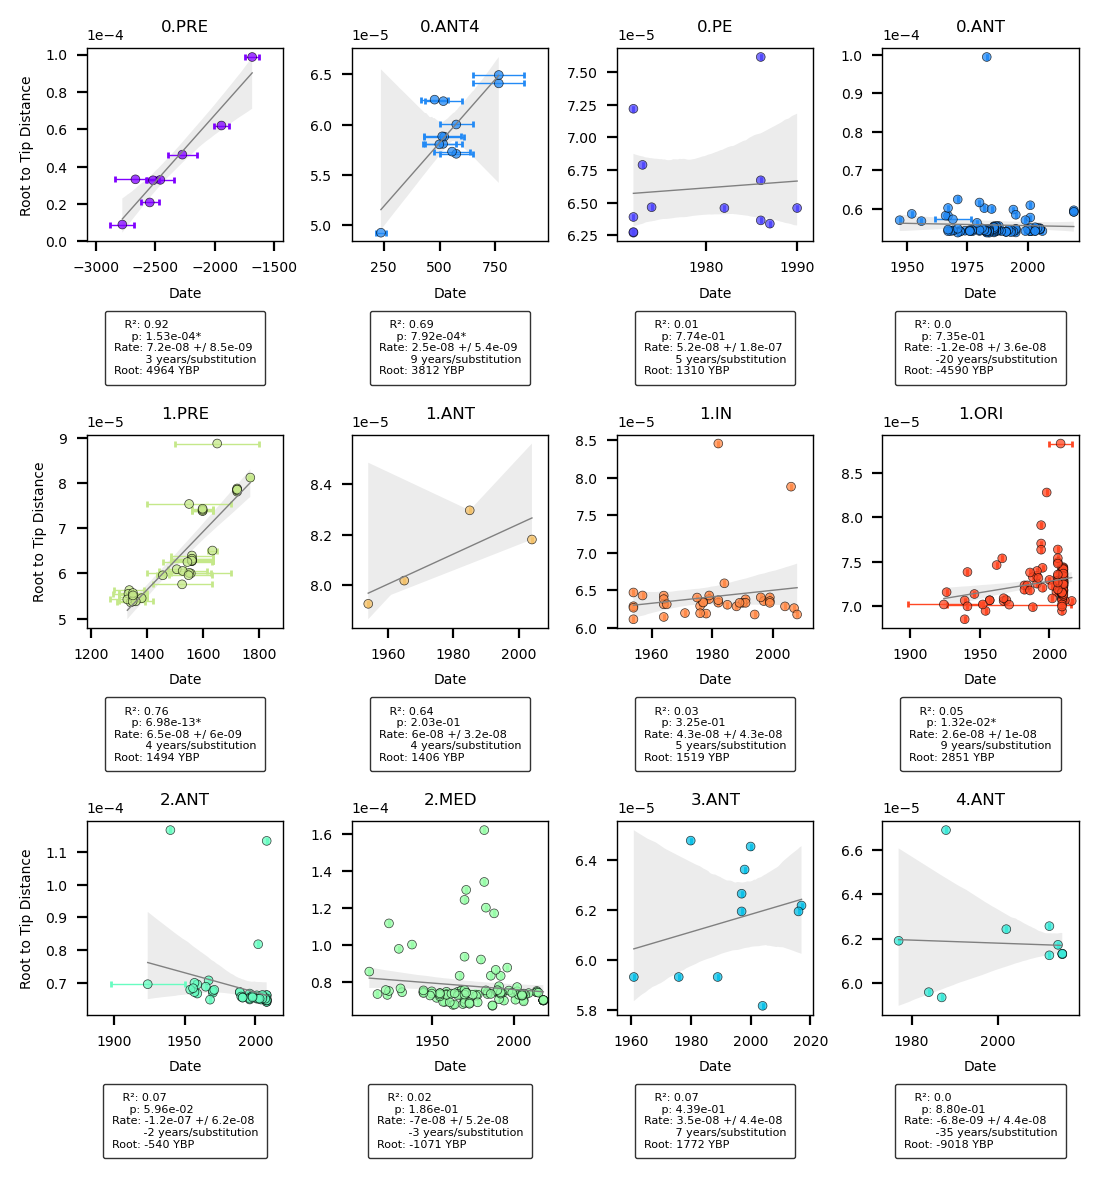

In [27]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)


nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=1)

i_row = 0
i_col = 0

for label in BRANCH_LIST:
    print("Branch:", label)
    
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]   
    
    # -----------------------
    # Regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df["date_mean"],df["rtt_dist"])
    r2 = r_value * r_value    
    y_intercept = CURRENT_YEAR - (0 - intercept)/slope
    p_sig = ""
    p_thresh = 0.05    
    if p_value < p_thresh:
        p_sig = "*"
        
    mut_per_year = SEQ_LEN * slope
    year_per_mut = 1 / mut_per_year
    
    reg_dict = {
        "slope": slope,
        "x_intercept" : intercept,
        "y_intercept" : y_intercept,
        "p_value" : p_value,
        "p_sig" : p_sig,
        "year_per_mut" : year_per_mut
    }
    
              
    sns.regplot(
        ax=ax,
        data=df, 
        x="date_mean", 
        y="rtt_dist", 
        #robust=True,
        ci=95,
        scatter_kws={"s": 0},
        line_kws={"linewidth" : 0.5},
        color="grey",
        #color=df["branch_major_color"][0],
        label=(
        "   R²: {}".format(round(r2,2))
        + "\n     p: {:.2e}{}".format(p_value, p_sig)
        + "\nRate: {:.2} +/ {:.2}".format(slope, std_err)  
        + "\n         {} years/substitution".format(round(year_per_mut))
        + "\nRoot: {} YBP".format(round(y_intercept))                
        )
    )
    
    ax.errorbar(
        data=df, 
        x="date_mean",
        y="rtt_dist", 
        xerr="date_err",
        yerr=None,
        ls='none',
        c = df["branch_major_color"][0],  
        capsize=1,
        label=None,
        zorder=1,
        lw=0.5,
        )  
    
    sns.scatterplot(
        ax=ax,
        data=df, 
        x="date_mean",
        s=10,
        y="rtt_dist", 
        c = df["branch_major_color"], 
        ec = "black",
        alpha=0.75,
        zorder=2,
    )    
    
    # Set xlimits
    xlim = ax.get_xlim()
    x_buff = round((xlim[1] - xlim[0]) * 0.1,1)
    new_xlim = [xlim[0]-x_buff, xlim[1]+x_buff]
    if new_xlim[1] > CURRENT_YEAR:
        new_xlim = [new_xlim[0], CURRENT_YEAR]
    ax.set_xlim(new_xlim)

    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.55), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)
        
    # Format axis
    ax.set_title(label)

    if i_col == 0:
        ax.set_ylabel("Root to Tip Distance")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Date")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1
        
    
out_path = os.path.join(out_dir, "rtt_clades")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

# Tip Dating

Branch: 0.PRE
Branch: 0.ANT4
Branch: 1.PRE


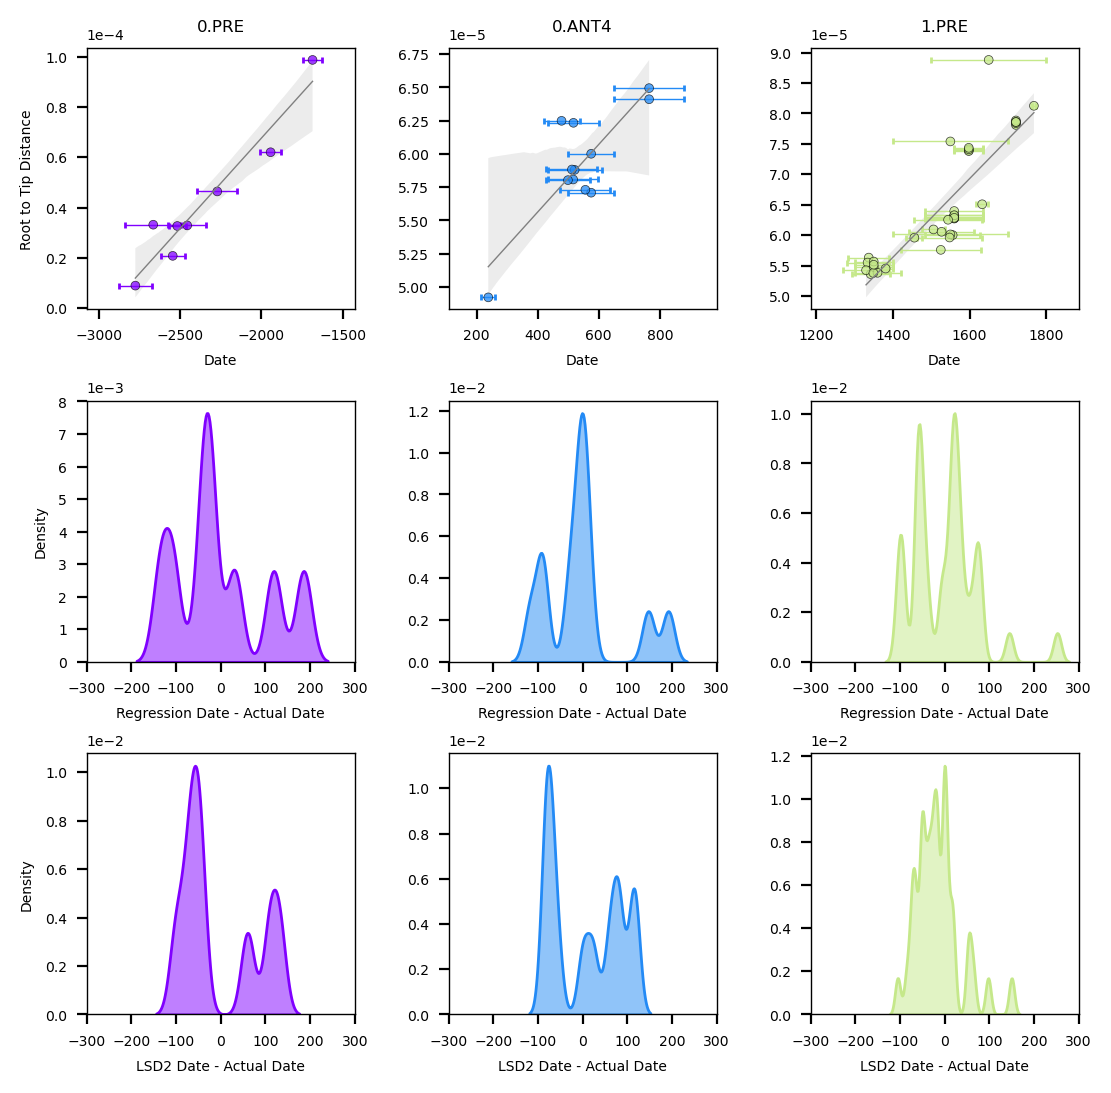

In [28]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)


nrow=3
ncol=3

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=0.35)
#fig.subplots_adjust(wspace=0.35, hspace=0.85)

for row in axes:
    for ax in row:
        for spine in ax.spines:
            ax.spines[spine].set_linewidth(0.5) 

i_row = 0
i_col = 0

for label in ANCIENT_BRANCH_LIST:
    print("Branch:", label)
    
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]   
    
    # -----------------------
    # Regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df["date_mean"],df["rtt_dist"])
    r2 = r_value * r_value    
    y_intercept = CURRENT_YEAR - (0 - intercept)/slope
    p_sig = ""
    p_thresh = 0.05    
    if p_value < p_thresh:
        p_sig = "*"
        
    mut_per_year = SEQ_LEN * slope
    year_per_mut = 1 / mut_per_year
    
    reg_dict = {
        "slope": slope,
        "x_intercept" : intercept,
        "y_intercept" : y_intercept,
        "p_value" : p_value,
        "p_sig" : p_sig,
        "year_per_mut" : year_per_mut
    }
    
              
    sns.regplot(
        ax=ax,
        data=df, 
        x="date_mean", 
        y="rtt_dist", 
        #robust=True,
        ci=95,
        scatter_kws={"s": 0},
        line_kws={"linewidth" : 0.5},
        color="grey",
        #color=df["branch_major_color"][0],
        label=(
        "   R²: {}".format(round(r2,2))
        + "\n     p: {:.2e}{}".format(p_value, p_sig)
        + "\nRate: {:.2} +/ {:.2}".format(slope, std_err)  
        + "\n         {} years/substitution".format(round(year_per_mut))
        + "\nRoot: {} YBP".format(round(y_intercept))                
        )
    )
    
    ax.errorbar(
        data=df, 
        x="date_mean",
        y="rtt_dist", 
        xerr="date_err",
        yerr=None,
        ls='none',
        c = df["branch_major_color"][0],  
        capsize=1,
        label=None,
        zorder=1,
        lw=0.5,
        )  
    
    sns.scatterplot(
        ax=ax,
        data=df, 
        x="date_mean",
        s=10,
        y="rtt_dist", 
        c = df["branch_major_color"], 
        ec = "black",
        alpha=0.75,
        zorder=2,
    )    
    
        
    # Set xlimits
    xlim = ax.get_xlim()
    x_buff = round((xlim[1] - xlim[0]) * 0.1,1)
    new_xlim = [xlim[0]-x_buff, xlim[1]+x_buff]
    if new_xlim[1] > CURRENT_YEAR:
        new_xlim = [new_xlim[0], CURRENT_YEAR]
    ax.set_xlim(new_xlim)
    """
    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.55), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)"""
    ax.get_legend().remove()
    
    # Format axis
    ax.set_title(label)

    if i_col == 0:
        ax.set_ylabel("Root to Tip Distance")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Date")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
      
            
    # Now predicted values
    i_row += 1
    ax = axes[i_row][i_col]    
    
    date_diffs = []
    for date_mean, rtt_dist in zip(df["date_mean"], df["rtt_dist"]):
        pred_date = (rtt_dist - reg_dict["x_intercept"]) / reg_dict["slope"]
        date_diff = pred_date - date_mean
        date_diffs.append(date_diff)
        
    sns.kdeplot(
       date_diffs,
       ax=ax,
       fill=True, 
       common_norm=True,
       alpha=0.5, 
       linewidth=1,
       bw_adjust=0.25,
       color=df["branch_major_color"][0],
    )
    
    if i_col == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Regression Date - Actual Date")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))  
    ax.set_xlim(-300,300)    

    # ---------------------------------------------------------------
    # Diff based on LSD2 estimate
    i_row += 1
    ax = axes[i_row][i_col]  
    
    date_diffs = []
    for date_mean, timetree_date in zip(df["date_mean"], df["timetree_date"]):
        date_est = CURRENT_YEAR + float(timetree_date)
        date_diff = date_est - date_mean
        date_diffs.append(date_diff)  
        
    sns.kdeplot(
       date_diffs,
       ax=ax,
       fill=True, 
       common_norm=True,
       alpha=0.5, 
       linewidth=1,
       bw_adjust=0.25,
       color=df["branch_major_color"][0],
    )
    
    if i_col == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("LSD2 Date - Actual Date")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))   
    ax.set_xlim(-300,300)
    
    # Update axis
    i_row = 0
    i_col += 1


out_path = os.path.join(out_dir, "tip-dating")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

In [29]:
print("All:", len(metadata_gdf))
print("Ancient:",len(ancient_gdf), len(ancient_gdf) / len(metadata_gdf))
print("Ancient:",len(modern_gdf), len(modern_gdf) / len(metadata_gdf))

All: 1201
Ancient: 61 0.0507910074937552
Ancient: 540 0.4496253122398002


In [30]:
"""TARGET_RES = [1280, 720]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
fig, ax = plt.subplots(1, dpi=DPI, figsize=FIGSIZE)

rtt_dist_ln = []
for rtt_dist in df["rtt_dist"]:
    rtt_dist_ln.append(math.log(rtt_dist))

sns.kdeplot(
   rtt_dist_ln,
    ax=ax,
)"""

'TARGET_RES = [1280, 720]\nDPI=200\nFIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]\nfig, ax = plt.subplots(1, dpi=DPI, figsize=FIGSIZE)\n\nrtt_dist_ln = []\nfor rtt_dist in df["rtt_dist"]:\n    rtt_dist_ln.append(math.log(rtt_dist))\n\nsns.kdeplot(\n   rtt_dist_ln,\n    ax=ax,\n)'

---
# Geography

## Isolation By Distance

### Prep Data

In [31]:
ibd_dict = {}

for label in BRANCH_LIST:
    print("Label:", label)    
    ibd_dict[label] = {"geo_dist" : [], "genetic_dist" : []}
    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]   
    
    i_compare = 0
    i = 0
    for sample1 in df.index:
        geom1 = df["geometry"][sample1]
        coord1 = (geom1.y, geom1.x)  
        for sample2 in df.index[i_compare:]:
            if sample1 == sample2: continue
            geom2 = df["geometry"][sample2]
            coord2 = (geom2.y, geom2.x)
            geo_dist = geopy.distance.great_circle(coord1, coord2).km
            genetic_dist = divtree.distance(sample1, sample2)

            ibd_dict[label]["geo_dist"].append(geo_dist)
            ibd_dict[label]["genetic_dist"].append(genetic_dist)
        i_compare += 1

Label: 0.PRE
Label: 0.ANT4
Label: 0.PE
Label: 0.ANT
Label: 1.PRE
Label: 1.ANT
Label: 1.IN
Label: 1.ORI
Label: 2.ANT
Label: 2.MED
Label: 3.ANT
Label: 4.ANT


### All

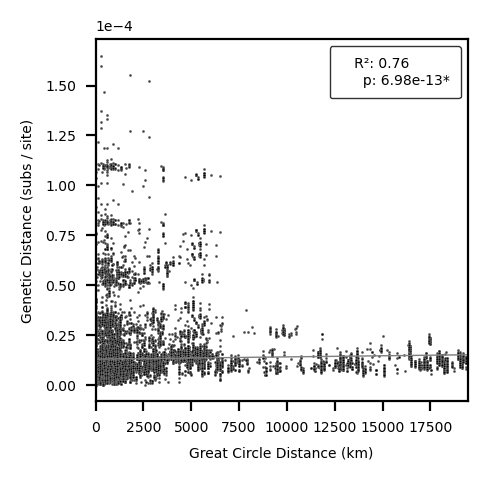

In [32]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

geo_dist_all = []
genetic_dist_all = []

fig, ax = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)

for branch in ibd_dict:
    geo_dist_all = geo_dist_all + ibd_dict[branch]["geo_dist"]
    genetic_dist_all = genetic_dist_all + ibd_dict[branch]["genetic_dist"]

sns.regplot(
    ax=ax,
    x=geo_dist_all,
    y=genetic_dist_all,
    ci=95,
    scatter_kws={"s": 0},
    color="grey",
    line_kws={"linewidth":0.5},
    label=(
    "   R²: {}".format(round(r2,2))
    + "\n     p: {:.2e}{}".format(p_value, p_sig)             
    )
)
    
sns.scatterplot(
    ax=ax,
    x=geo_dist_all,
    y=genetic_dist_all,
    s=1,
    ec = "white", 
    color="black",
    alpha=0.75,
    zorder=2,
)

# Format and position legend
legend = ax.legend(
    borderpad=0.8, 
    handletextpad=-2, 
    edgecolor="black", 
    #bbox_to_anchor=(0.5, -0.30), 
    #loc='center',
    fontsize=FONTSIZE,
)
frame = legend.get_frame().set_linewidth(0.5)

ax.set_ylabel("Genetic Distance (subs / site)")
ax.set_xlabel("Great Circle Distance (km)")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    

out_path = os.path.join(out_dir, "ibd_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

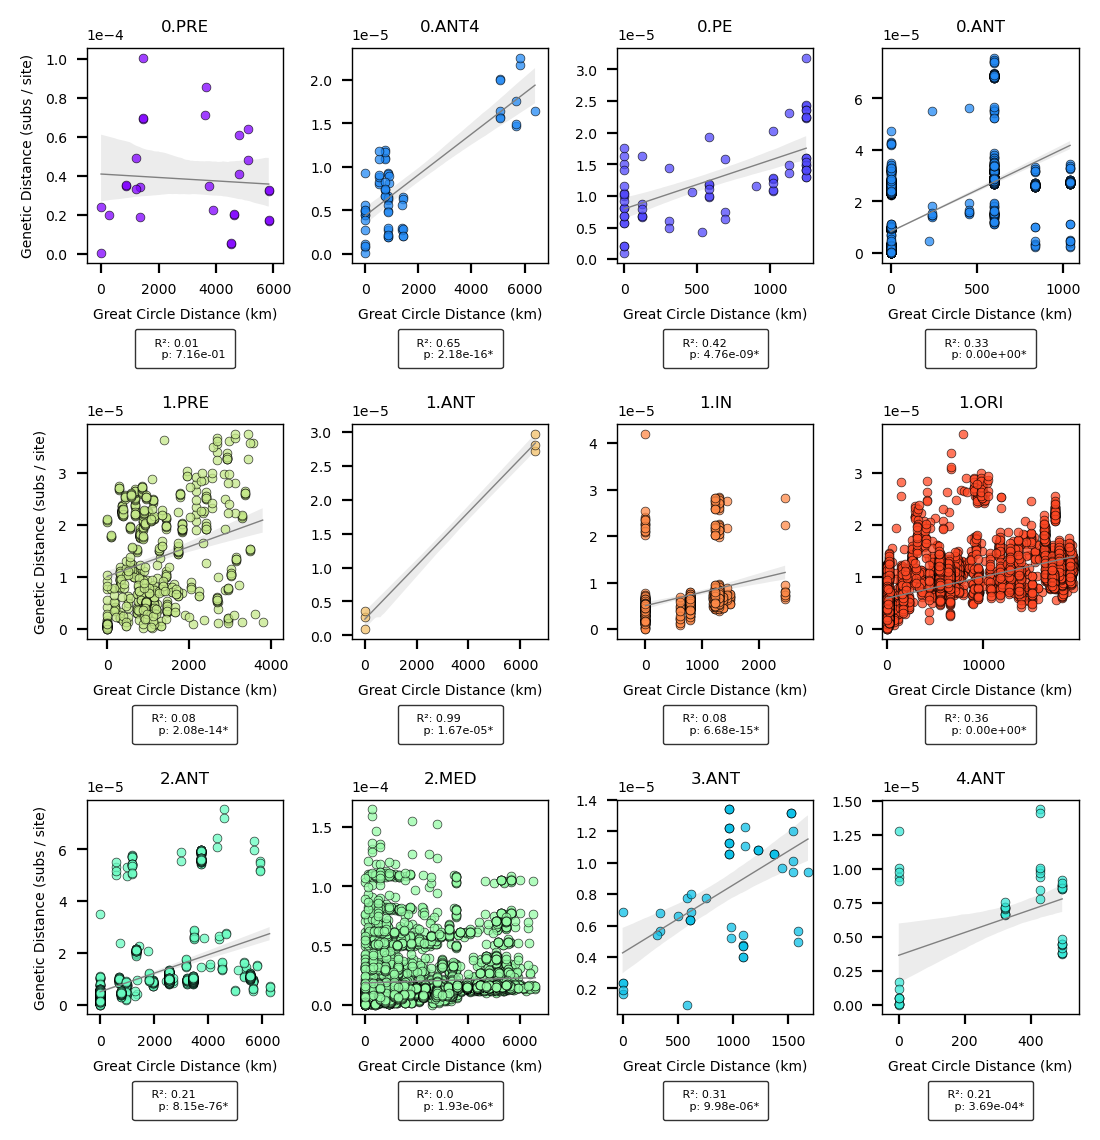

In [33]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=0.75)


i_row = 0
i_col = 0

for label in BRANCH_LIST:
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]   
    
    for branch_major in colors_dict:
        if branch_major in label:
            break  
            
    # -----------------------
    # Regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ibd_dict[label]["geo_dist"],ibd_dict[label]["genetic_dist"])
    r2 = r_value * r_value    
    y_intercept = CURRENT_YEAR - (0 - intercept)/slope
    p_sig = ""
    p_thresh = 0.05    
    if p_value < p_thresh:
        p_sig = "*"
        
    mut_per_year = SEQ_LEN * slope
    year_per_mut = 1 / mut_per_year
    
    reg_dict = {
        "slope": slope,
        "x_intercept" : intercept,
        "y_intercept" : y_intercept,
        "p_value" : p_value,
        "p_sig" : p_sig,
        "year_per_mut" : year_per_mut
    }
    
    sns.regplot(
        ax=ax,
        x=ibd_dict[label]["geo_dist"],
        y=ibd_dict[label]["genetic_dist"],
        ci=95,
        scatter_kws={"s": 0},
        color="grey",
        line_kws={"linewidth":0.5},
        label=(
        "   R²: {}".format(round(r2,2))
        + "\n     p: {:.2e}{}".format(p_value, p_sig)             
        )
    )

    sns.scatterplot(
        ax=ax,
        x=ibd_dict[label]["geo_dist"],
        y=ibd_dict[label]["genetic_dist"],
        s=10,
        ec = "black",
        color = colors_dict[branch_major],         
        alpha=0.75,
        zorder=2,
    )
     
    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.40), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)        
    
    # Set xlimits
    xlim = ax.get_xlim()
    if xlim[1] > 20000:
        xbuff = 5000   
    elif xlim[1] > 2000:
        xbuff = 500
    elif xlim[1] > 200:
        xbuff = 50
    ax.set_xlim(0-xbuff, xlim[1] + xbuff)
        
    # Format axis
    ax.set_title(label)

    if i_col == 0:
        ax.set_ylabel("Genetic Distance (subs / site)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Great Circle Distance (km)")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1

    
out_path = os.path.join(out_dir, "ibd_clades")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Map

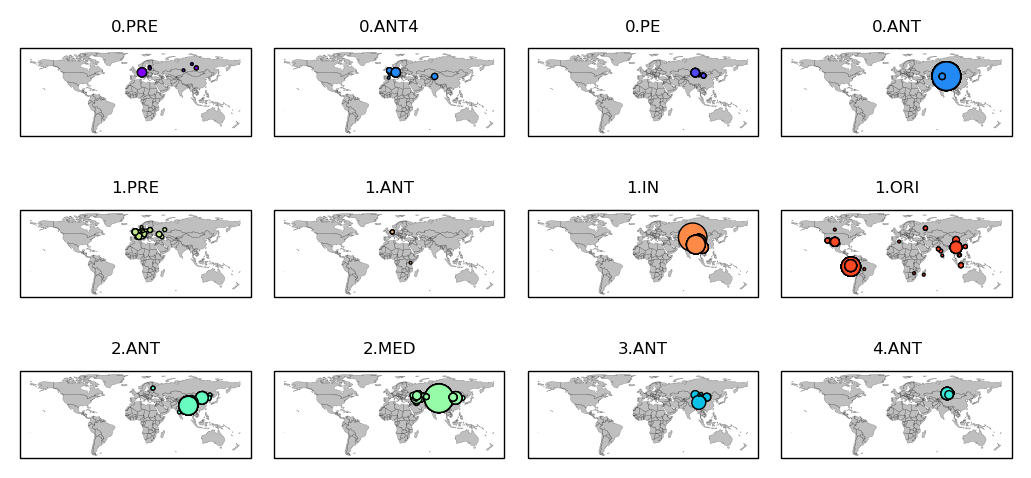

In [34]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

nrow=3
ncol=4

fig, axes = plt.subplots(nrow, ncol, subplot_kw={'projection': CRS_EPSG},
                        figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.1, hspace=-0.75)
i_row = 0
i_col = 0

for label in BRANCH_LIST:
    
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]   
    
    for branch_major in colors_dict:
        if branch_major in label:
            break  
    
    # --------------------------------------
    # World Basemap
    world_polygons.plot(
        ax=ax, 
        zorder=1, 
        alpha=0.5, 
        color="grey",
        edgecolor="black", 
        linewidth=0.1,
    ) 

    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]   
    df.plot(ax=ax, ec="black", lw=0.5, color=colors_dict[branch_major], markersize=df["geometry_size"], linewidth=0.5)

    # Sorry Antarctica
    ax.set_ylim(-60,90)
    
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)        
    
    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1
        
out_path = os.path.join(out_dir, "map_clades")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

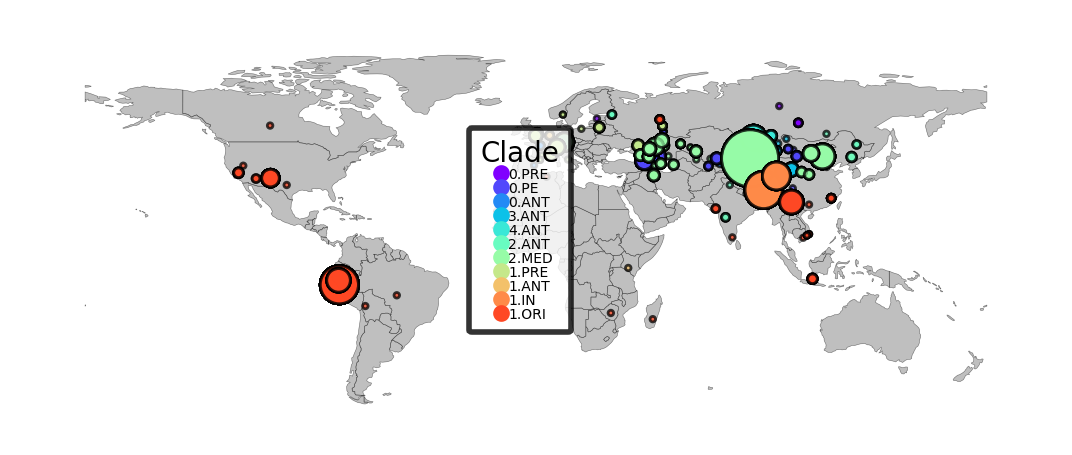

In [35]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=400
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5

## All
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},
                        figsize=FIGSIZE, dpi=DPI)
world_polygons.plot(
    ax=ax, 
    zorder=1, 
    alpha=0.5, 
    color="grey",
    edgecolor="black", 
    linewidth=0.1,
) 

metadata_gdf.plot(
    ax=ax, 
    ec="black", 
    lw=0.5, 
    color=metadata_gdf["branch_major_color"], 
    markersize=metadata_gdf["geometry_size"], 
    linewidth=0.5,
    alpha=0.75,
)

ax.axis("off")

# Sorry Antarctica
ax.set_ylim(-60,90)

clade_lines = [lines.Line2D([0], [0], color=colors_dict[state], lw=0, markersize=2, marker="o") 
                for state in colors_dict]
clade_labels = [state for state in colors_dict]

clade_legend = fig.legend(clade_lines, 
           clade_labels,
           #ncol=len(clade_labels),
           ncol=1,
           loc="center", 
           bbox_to_anchor=(0.5, 0.50),
           frameon=True,
            borderpad=0.8, 
            handletextpad=-0.5, 
           labelspacing=0,
           edgecolor="black",
           title="Clade",
           fontsize=FONTSIZE / 2,
           title_fontsize=FONTSIZE,
          )

out_path = os.path.join(out_dir, "map_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Modern Human Plague Cases

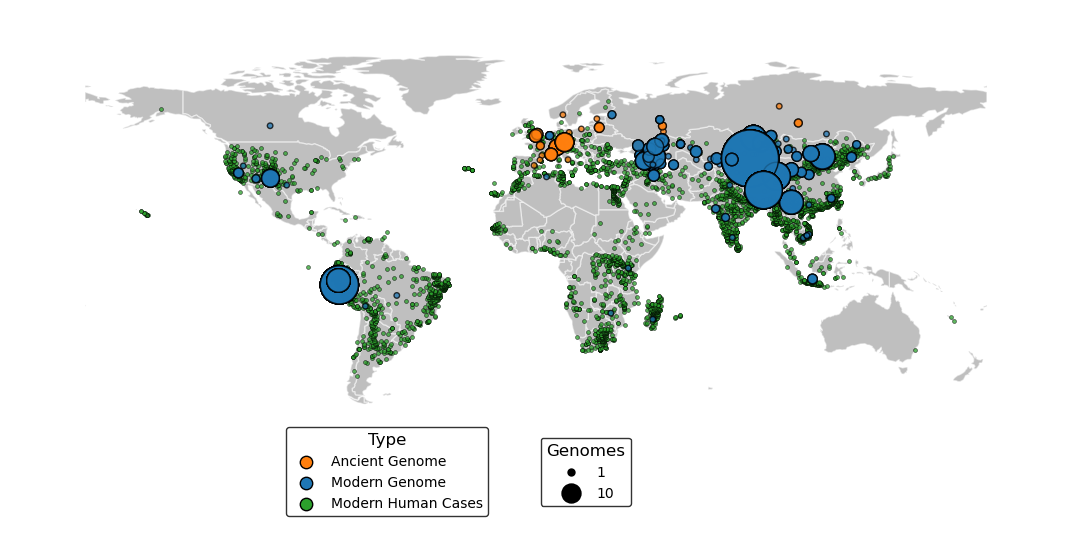

In [36]:
TARGET_RES = [1280, 1280]
DPI=400
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
plt.rc("legend", title_fontsize=MED_FONT)  # fontsize of the legend title
plt.rc("legend", fontsize=MED_FONT)  # fontsize of the legend title

fig, ax_map = plt.subplots(1, dpi=DPI, figsize=FIGSIZE)
# --------------------------------------
# World Basemap
world_poly = world_polygons.plot(
    ax=ax_map, 
    zorder=1, 
    alpha=0.5, 
    color="grey",
    edgecolor="white", 
    linewidth=0.25,
)
xu_2019_gdf.plot(ax=ax_map,  markersize=0.5, alpha=0.75, ec="black", lw=0.1, c=D3_PAL[2])
ancient_gdf.plot(ax=ax_map,  markersize=ancient_gdf["geometry_size"], alpha=0.75, ec="black", lw=0.25, c=D3_PAL[1])
modern_gdf.plot(ax=ax_map,  markersize=modern_gdf["geometry_size"], alpha=0.75, ec="black", lw=0.25, c=D3_PAL[0])
# Sorry Antarctica
ax_map.set_ylim(-60,90)
ax_map.axis('off')  

out_path = os.path.join(out_dir, "map_xu-2019")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

# Origin Legend
o = [ax_map.scatter(0,-9000, s=5, ec="black", marker="o", c=D3_PAL[1], lw=0.25),
     ax_map.scatter(0,-9000, s=5, ec="black", marker="o", c=D3_PAL[0], lw=0.25),
     ax_map.scatter(0,-9000, s=5, ec="black", marker="o", c=D3_PAL[2], lw=0.25),     
    ]
ol = ["Ancient Genome", "Modern Genome", "Modern Human Cases"]

leg_origin = plt.legend(
    o, ol, title="Type", loc="center", bbox_to_anchor=[0.35,-0.15], edgecolor="black",
    fontsize=FONTSIZE / 2, title_fontsize=FONTSIZE - 2)
leg_origin.get_frame().set_linewidth(0.25)

# Size Legend
s = [ax_map.scatter(0,-9000, s=1, ec="black", c="black", lw=0.5),
     ax_map.scatter(0,-9000, s=10, ec="black", c="black", lw=0.5),  
    ]
sl = ["1", "10"]
leg_size = plt.legend(s, sl, title="Genomes", loc="center", bbox_to_anchor=[0.55,-0.15], edgecolor="black",
                    fontsize=FONTSIZE / 2, title_fontsize=FONTSIZE - 2)
leg_size.get_frame().set_linewidth(0.25)

ax_map.add_artist(leg_origin)

out_path = os.path.join(out_dir, "map_comparison")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

---
# Export

In [51]:
comment_columns = [
    "node_type", 
    "branch_support",
    "timetree_date",
    "mugration_country",
    "mugration_province",
    "mugration_branch_major",
    "mugration_country_lat",
    "mugration_country_lon",
    "mugration_country_confidence",
    "mugration_province_lat",
    "mugration_province_lon",
    "mugration_province_confidence",    
    "geometry_size",
    "divtree_coord_x",
    "divtree_coord_y",
    "rtt_dist",
    "branch_major_color",
    "timetree_coord_x",
    "timetree_coord_y",
    "timetree_CI_height",
]

comment_gdf = metadata_gdf[comment_columns]
display(comment_gdf)


,node_type,branch_support,timetree_date,mugration_country,mugration_province,mugration_branch_major,mugration_country_lat,mugration_country_lon,mugration_country_confidence,mugration_province_lat,mugration_province_lon,mugration_province_confidence,geometry_size,divtree_coord_x,divtree_coord_y,rtt_dist,branch_major_color,timetree_coord_x,timetree_coord_y,timetree_CI_height
sample,,,,,,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,terminal,100.0,-98,Russia,Rostov Oblast,2.MED,64.686314,97.745306,1.000000,47.622245,40.795794,1.000000,4.0,0.000073,339.00,0.000073,#97fca7,6259.03230,339.00,NA
GCA_009669545.1_ASM966954v1_genomic,terminal,100.0,-15,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,105.0,0.000054,152.00,0.000054,#238af5,6342.03339,152.00,NA
GCA_009669555.1_ASM966955v1_genomic,terminal,100.0,-16,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,105.0,0.000055,171.00,0.000055,#238af5,6341.03334,171.00,NA
GCA_009669565.1_ASM966956v1_genomic,terminal,100.0,-16,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,105.0,0.000055,173.00,0.000055,#238af5,6341.03334,173.00,NA
GCA_009669605.1_ASM966960v1_genomic,terminal,100.0,-16,China,Xinjiang,0.ANT,35.000074,104.999927,1.000000,42.480495,85.463346,1.000000,105.0,0.000055,165.00,0.000055,#238af5,6341.03334,165.00,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE595,internal,13.0,-147.664,Peru,Cajamarca,1.ORI,-6.869970,-75.045851,1.000000,-6.250000,-78.833333,0.994564,18.0,0.000072,598.25,0.000072,#ff4824,6209.36816,598.25,"{150.036,212.137}"
NODE596,internal,13.0,-147.664,Peru,Cajamarca,1.ORI,-6.869970,-75.045851,1.000000,-6.250000,-78.833333,0.994580,18.0,0.000072,596.75,0.000072,#ff4824,6209.36816,596.75,"{150.036,212.137}"
NODE597,internal,46.0,-108.537,Peru,Cajamarca,1.ORI,-6.869970,-75.045851,0.999997,-6.250000,-78.833333,0.999921,18.0,0.000073,597.50,0.000073,#ff4824,6248.49486,597.50,"{92.2612,187.129}"


In [52]:
out_timetree = copy.deepcopy(timetree)

for c in out_timetree.find_clades():
    if not c.confidence:
        c.confidence = 0

metadata_to_comment(out_timetree, comment_gdf)    
out_timetree_path = os.path.join(out_dir, "final.nex")
Phylo.write(out_timetree, out_timetree_path, "nexus")

1